<a href="https://colab.research.google.com/github/torrozz/Graduation/blob/main/Graduation_verBreast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi


Sat May 24 03:30:25 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   53C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
# Upload file json
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nguyntntjason","key":"a77661f4fc309da9ac836ae66d9cbd10"}'}

In [ ]:
# Cài đặt kaggle CLI
!pip install -q kaggle

# Tạo thư mục và di chuyển file json vào vị trí mặc định
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
# Tải file zip từ Kaggle dataset Paul Mooney
!kaggle datasets download -d paultimothymooney/breast-histopathology-images


Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/breast-histopathology-images
License(s): CC0-1.0
 97% 3.01G/3.10G [01:24<00:06, 13.2MB/s]
100% 3.10G/3.10G [01:25<00:00, 39.1MB/s]


In [ ]:
# Giải nén dữ liệu
!unzip breast-histopathology-images.zip -d breast_histopathology_data


Streaming output truncated to the last 5000 lines.
  inflating: breast_histopathology_data/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1551_class0.png  
  inflating: breast_histopathology_data/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1601_class0.png  
  inflating: breast_histopathology_data/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1651_class0.png  
  inflating: breast_histopathology_data/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1701_class0.png  
  inflating: breast_histopathology_data/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1751_class0.png  
  inflating: breast_histopathology_data/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1801_class0.png  
  inflating: breast_histopathology_data/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1851_class0.png  
  inflating: breast_histopathology_data/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1901_class0.png  
  inflating: breast_histopathology_data/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1951_class0.png  
  inflating: 

In [ ]:
# Đếm số thư mục bệnh nhân
!find breast_histopathology_data/IDC_regular_ps50_idx5 -type d | wc -l

# Xem vài file đầu tiên
!find breast_histopathology_data/IDC_regular_ps50_idx5 -type f | head -10


838
breast_histopathology_data/IDC_regular_ps50_idx5/12955/0/12955_idx5_x2101_y2001_class0.png
breast_histopathology_data/IDC_regular_ps50_idx5/12955/0/12955_idx5_x1751_y2051_class0.png
breast_histopathology_data/IDC_regular_ps50_idx5/12955/0/12955_idx5_x751_y701_class0.png
breast_histopathology_data/IDC_regular_ps50_idx5/12955/0/12955_idx5_x2251_y151_class0.png
breast_histopathology_data/IDC_regular_ps50_idx5/12955/0/12955_idx5_x2551_y2001_class0.png
breast_histopathology_data/IDC_regular_ps50_idx5/12955/0/12955_idx5_x901_y1001_class0.png
breast_histopathology_data/IDC_regular_ps50_idx5/12955/0/12955_idx5_x1551_y2351_class0.png
breast_histopathology_data/IDC_regular_ps50_idx5/12955/0/12955_idx5_x501_y401_class0.png
breast_histopathology_data/IDC_regular_ps50_idx5/12955/0/12955_idx5_x2251_y1951_class0.png
breast_histopathology_data/IDC_regular_ps50_idx5/12955/0/12955_idx5_x1001_y751_class0.png


In [ ]:
import os
import shutil
import random
from pathlib import Path

# Đường dẫn tới thư mục dữ liệu đã giải nén
source_dir = Path("breast_histopathology_data")

# Thư mục đích chứa dữ liệu đã sắp xếp
base_dir = Path("working_dir/data")
train_dir = base_dir / "train"
valid_dir = base_dir / "valid"

# Tạo cấu trúc thư mục train/valid và nhãn 0, 1
for split in [train_dir, valid_dir]:
    (split / "0").mkdir(parents=True, exist_ok=True)
    (split / "1").mkdir(parents=True, exist_ok=True)

# Gom danh sách các ảnh (với label tương ứng: 0 hoặc 1)
image_paths = []
for patient_dir in source_dir.iterdir():
    if patient_dir.is_dir():
        for label_dir in patient_dir.iterdir():
            if label_dir.name in ['0', '1']:
                for img_file in label_dir.iterdir():
                    image_paths.append((img_file, label_dir.name))

# Shuffle và chia 80% train - 20% valid
random.seed(42)
random.shuffle(image_paths)
split_idx = int(len(image_paths) * 0.8)
train_set = image_paths[:split_idx]
valid_set = image_paths[split_idx:]

# Hàm copy ảnh
def copy_images(dataset, target_dir):
    for img_path, label in dataset:
        dst = target_dir / label / img_path.name
        shutil.copy(img_path, dst)

# Thực hiện sao chép ảnh
copy_images(train_set, train_dir)
copy_images(valid_set, valid_dir)

print(f"✅ Đã sắp xếp {len(train_set)} ảnh vào tập huấn luyện và {len(valid_set)} ảnh vào tập validation.")


✅ Đã sắp xếp 222019 ảnh vào tập huấn luyện và 55505 ảnh vào tập validation.


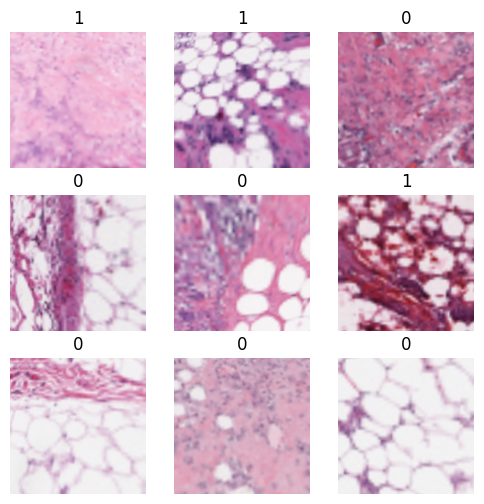

In [ ]:
from fastai.vision.all import *

# Đường dẫn đến thư mục chứa ảnh đã chia train/valid
data_path = Path("working_dir/data")

# Tạo DataLoaders từ thư mục với các augmentation giống như trước
dls = ImageDataLoaders.from_folder(
    data_path,
    train='train',
    valid='valid',
    item_tfms=Resize(460),  # Resize lớn trước khi crop để giữ chi tiết
    batch_tfms=aug_transforms(
        size=224,            # Sau đó crop 224x224 phù hợp ResNet50
        flip_vert=True,
        max_rotate=20,
        max_zoom=1.2,
        max_lighting=0.3,
        max_warp=0.3,
        p_affine=0.75,
        p_lighting=0.75
    ),
    bs=64  # Batch size như bạn dùng trước
)

# Kiểm tra lại 1 batch ảnh
dls.show_batch(max_n=9, figsize=(6,6))


In [ ]:
# Khởi tạo mô hình learner với ResNet50
learn = cnn_learner(
    dls,                # DataLoaders đã tạo ở bước 4
    resnet50,           # Backbone CNN
    metrics=accuracy,   # Đo lường accuracy
    pretrained=True     # Dùng trọng số pre-trained ImageNet
)




In [ ]:
# Huấn luyện mô hình 5 epochs với learning rate tối ưu tìm được
learn.fine_tune(5, base_lr=1e-3)


epoch,train_loss,valid_loss,accuracy,time
0,0.333384,0.282001,0.881309,25:01


epoch,train_loss,valid_loss,accuracy,time
0,0.210955,0.166052,0.938257,32:44
1,0.142069,0.114101,0.959845,32:40
2,0.109754,0.095081,0.966845,32:38
3,0.100544,0.084995,0.971094,32:47


epoch,train_loss,valid_loss,accuracy,time
0,0.210955,0.166052,0.938257,32:44
1,0.142069,0.114101,0.959845,32:40
2,0.109754,0.095081,0.966845,32:38
3,0.100544,0.084995,0.971094,32:47
4,0.100601,0.082429,0.972321,32:31


In [ ]:
learn.export("/content/breast_cancer.pkl")


In [ ]:
from google.colab import files
files.download("/content/breast_cancer.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

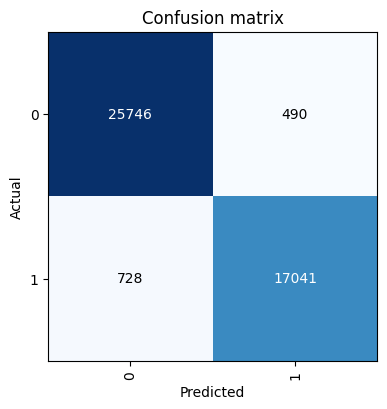

In [ ]:
# Ma trận nhầm lẫn để xem dự đoán đúng/sai
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(4,4), dpi=100)


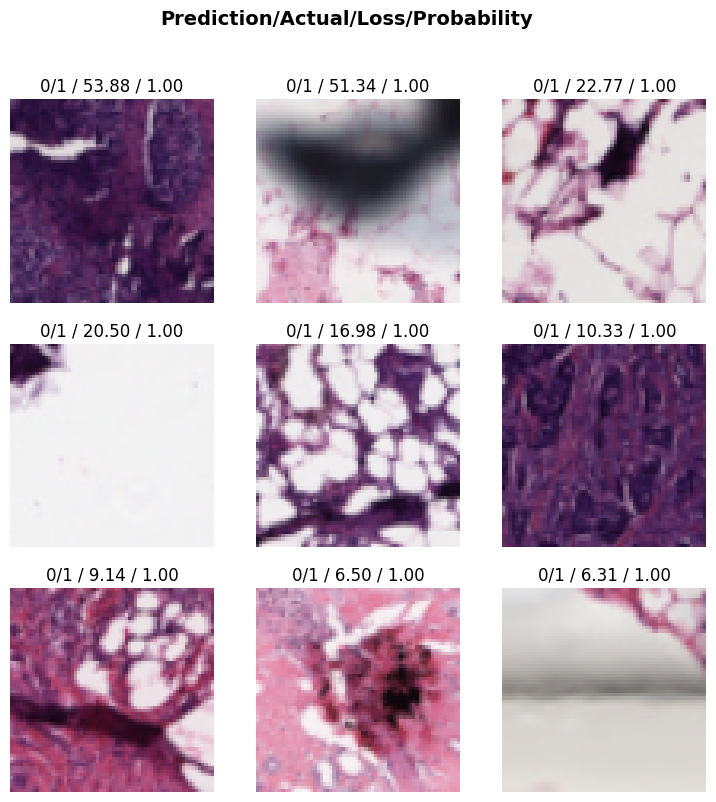

In [ ]:
interp.plot_top_losses(9, nrows=3, figsize=(9,9))


In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
# Lấy nhãn thực và xác suất dự đoán lớp 1 (IDC)
preds, targs = learn.get_preds()
pred_probs = preds[:,1]  # Xác suất cho lớp 1


In [ ]:
# Tính FPR, TPR
fpr, tpr, _ = roc_curve(targs, pred_probs)
roc_auc = auc(fpr, tpr)


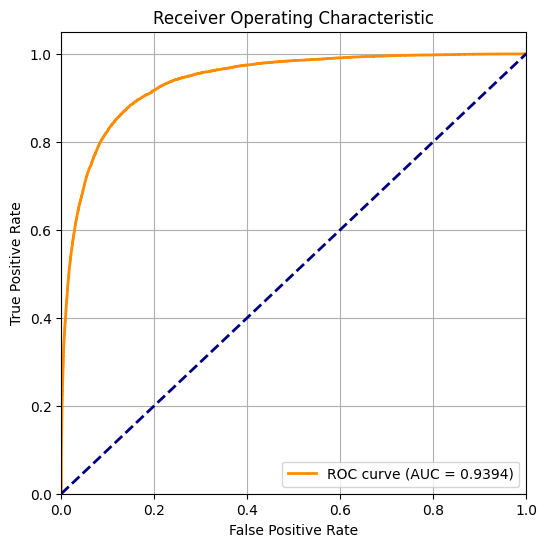

In [ ]:
# Vẽ đường cong ROC
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.grid()
plt.show()


In [ ]:
learn.export("/content/breast_cancer_model.pkl")


In [ ]:
from google.colab import files
files.download("/content/breast_cancer_model.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from fastai.vision.all import *

# Load mô hình đã huấn luyện từ file .pkl
learn = load_learner('metastatic_model.pkl')


In [ ]:
# Lưu lại chỉ phần trọng số (state_dict) của mô hình
torch.save(learn.model.state_dict(), 'metastatic_model.pth')


In [ ]:
# Tải file .pth về máy
files.download('metastatic_model.pth')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!cp "/content/drive/MyDrive/breast_cancer_model.pkl" /content/

In [ ]:
from fastai.vision.all import *


In [ ]:
learn.fine_tune(1)  # hoặc learn.fit(1)
learn.recorder.plot_loss()



NameError: name 'learn' is not defined

⬆️ Upload ảnh cần dự đoán...


Saving 8863_idx5_x1801_y1501_class1.png to 8863_idx5_x1801_y1501_class1.png


🧠 Dự đoán: 1
📊 Xác suất Non-IDC (0): 0.3332, IDC (1): 0.6668


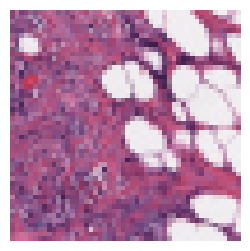

In [ ]:
from fastai.vision.all import *
from google.colab import files

# --- 1. Load mô hình đã upload trước đó ---
learn_inf = load_learner("breast_cancer_model.pkl")

# --- 2. Upload ảnh từ máy ---
print("⬆️ Upload ảnh cần dự đoán...")
uploaded_img = files.upload()
img_filename = next(iter(uploaded_img))  # lấy tên ảnh đầu tiên

# --- 3. Dự đoán ---
img = PILImage.create(img_filename)
pred_class, pred_idx, probs = learn_inf.predict(img)

# --- 4. Hiển thị ảnh và kết quả ---
img.show(figsize=(3,3))
print(f"🧠 Dự đoán: {pred_class}")
print(f"📊 Xác suất Non-IDC (0): {probs[0]:.4f}, IDC (1): {probs[1]:.4f}")


⬆️ Upload ảnh cần dự đoán...


Saving 8863_idx5_x1451_y1101_class1.png to 8863_idx5_x1451_y1101_class1.png


🧠 Dự đoán: 1
📊 Xác suất Non-IDC (0): 0.0980, IDC (1): 0.9020


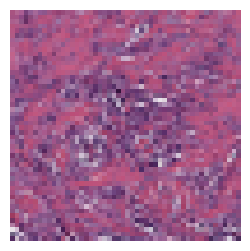

In [ ]:
from fastai.vision.all import *
from google.colab import files

# --- 1. Load mô hình đã upload trước đó ---
learn_inf = load_learner("breast_cancer.pkl")

# --- 2. Upload ảnh từ máy ---
print("⬆️ Upload ảnh cần dự đoán...")
uploaded_img = files.upload()
img_filename = next(iter(uploaded_img))  # lấy tên ảnh đầu tiên

# --- 3. Dự đoán ---
img = PILImage.create(img_filename)
pred_class, pred_idx, probs = learn_inf.predict(img)

# --- 4. Hiển thị ảnh và kết quả ---
img.show(figsize=(3,3))
print(f"🧠 Dự đoán: {pred_class}")
print(f"📊 Xác suất Non-IDC (0): {probs[0]:.4f}, IDC (1): {probs[1]:.4f}")

⬆️ Upload ảnh cần dự đoán...


Saving 8863_idx5_x1801_y1501_class1.png to 8863_idx5_x1801_y1501_class1 (1).png


🧠 Dự đoán: 1
📊 Xác suất Non-IDC (0): 0.3332, IDC (1): 0.6668
👉 Bạn có muốn dự đoán ảnh khác không? (y/n): y
⬆️ Upload ảnh cần dự đoán...


Saving 8867_idx5_x1251_y1151_class1.png to 8867_idx5_x1251_y1151_class1 (1).png


🧠 Dự đoán: 0
📊 Xác suất Non-IDC (0): 0.6707, IDC (1): 0.3293
👉 Bạn có muốn dự đoán ảnh khác không? (y/n): y
⬆️ Upload ảnh cần dự đoán...


Saving 8867_idx5_x1151_y1001_class1.png to 8867_idx5_x1151_y1001_class1.png


🧠 Dự đoán: 1
📊 Xác suất Non-IDC (0): 0.2391, IDC (1): 0.7609
👉 Bạn có muốn dự đoán ảnh khác không? (y/n): y
⬆️ Upload ảnh cần dự đoán...


Saving 8867_idx5_x1101_y1051_class1.png to 8867_idx5_x1101_y1051_class1.png


🧠 Dự đoán: 1
📊 Xác suất Non-IDC (0): 0.2255, IDC (1): 0.7745
👉 Bạn có muốn dự đoán ảnh khác không? (y/n): n
✅ Kết thúc dự đoán.


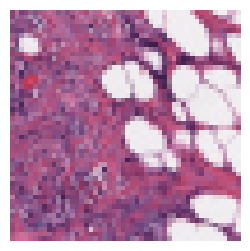

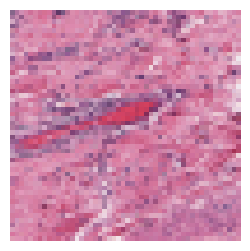

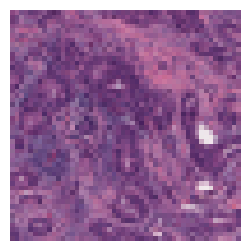

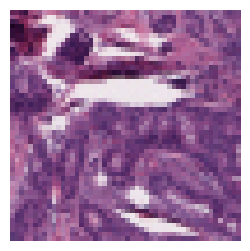

In [ ]:
from fastai.vision.all import *
from google.colab import files

# --- 1. Load mô hình đã có ---
learn_inf = load_learner("breast_cancer_model.pkl")

# --- 2. Lặp dự đoán ảnh liên tục ---
while True:
    print("⬆️ Upload ảnh cần dự đoán...")
    uploaded_img = files.upload()
    if not uploaded_img:
        print("🚫 Không có ảnh nào được upload. Kết thúc.")
        break

    img_filename = next(iter(uploaded_img))  # lấy tên file đầu tiên
    img = PILImage.create(img_filename)

    # Dự đoán
    pred_class, pred_idx, probs = learn_inf.predict(img)

    # Hiển thị ảnh + kết quả
    img.show(figsize=(3,3))
    print(f"🧠 Dự đoán: {pred_class}")
    print(f"📊 Xác suất Non-IDC (0): {probs[0]:.4f}, IDC (1): {probs[1]:.4f}")

    # Hỏi người dùng có muốn tiếp tục?
    again = input("👉 Bạn có muốn dự đoán ảnh khác không? (y/n): ").lower()
    if again != 'y':
        print("✅ Kết thúc dự đoán.")
        break


In [ ]:
from fastai.vision.all import *

# Tải lại mô hình từ file đã lưu
learn_inf = load_learner("/content/breast_cancer_model.pkl")

# Dự đoán 1 ảnh cụ thể từ tập validation
img = PILImage.create("/content/working_dir/data/valid/1/10253_idx5_x501_y401_class1.png")

# Thực hiện dự đoán
pred_class, pred_idx, probs = learn_inf.predict(img)

# Hiển thị kết quả
print(f"🧠 Dự đoán: {pred_class}")
print(f"📊 Xác suất Non-IDC (0): {probs[0]:.4f}, IDC (1): {probs[1]:.4f}")


🧠 Dự đoán: 0
📊 Xác suất Non-IDC (0): 0.5754, IDC (1): 0.4246


In [ ]:
# 1. Load lại DataLoaders giống như lúc train
dls = ImageDataLoaders.from_folder(
    "/content/working_dir/data",
    train="train",
    valid="valid",
    item_tfms=Resize(64),
    batch_tfms=aug_transforms(),
    bs=64
)

# 2. Gắn lại vào learn_inf
learn_inf.dls = dls


In [ ]:
# Lấy tất cả kết quả dự đoán
preds, targs = learn_inf.get_preds()
pred_labels = preds.argmax(dim=1)

# Xuất file CSV
import pandas as pd
df = pd.DataFrame({
    "Actual": targs,
    "Predicted": pred_labels,
    "Probability_nonIDC": preds[:, 0],
    "Probability_IDC": preds[:, 1]
})
df.to_csv("/content/validation_predictions.csv", index=False)

# Tải file về
from google.colab import files
files.download("/content/validation_predictions.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>